In [2]:
import numpy as np
import random
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
class UnionFind:
    """Union-Find structure to manage clusters of active traders."""

    def __init__(self, grid):
        """
        Initialize Union-Find for the grid of Trader objects.
        Args:
            grid: A 2D array of Trader objects.
        """
        self.height = len(grid)
        self.width = len(grid[0])
        self.grid = grid  # The 2D grid of Trader objects
        self.parents = [-1] * (
            self.height * self.width
        )  # Each cell starts as its own root
        self.sizes = [0] * (self.height * self.width)  # Cluster sizes

        # Initialize clusters for the given grid
        for i in range(self.height):
            for j in range(self.width):
                if grid[i][j].state != 0:  # Only consider active traders (+1 or -1)
                    self.parents[self._index(i, j)] = self._index(i, j)  # Set as root
                    self.sizes[self._index(i, j)] = 1

    def _index(self, i, j):
        """Convert 2D coordinates to a 1D index."""
        return i * self.width + j

    def _coordinates(self, index):
        """Convert a 1D index back to 2D coordinates."""
        return index // self.width, index % self.width

    def find(self, x):
        """Find the root of the set containing x with path compression."""
        if self.parents[x] != x:
            self.parents[x] = self.find(self.parents[x])
        return self.parents[x]

    def union(self, x, y):
        """Union the sets containing x and y."""
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x != root_y:
            # Union by size
            if self.sizes[root_x] < self.sizes[root_y]:
                root_x, root_y = root_y, root_x
            self.parents[root_y] = root_x
            self.sizes[root_x] += self.sizes[root_y]

    def get_cluster_configuration(self):
        """Get the configuration of clusters: sizes and coordinates."""
        clusters = {}
        for i in range(self.height):
            for j in range(self.width):
                if self.grid[i][j].state != 0:  # Active trader
                    root = self.find(self._index(i, j))
                    if root not in clusters:
                        clusters[root] = {"size": 0, "cells": []}
                    clusters[root]["size"] += 1
                    clusters[root]["cells"].append((i, j))
        return clusters


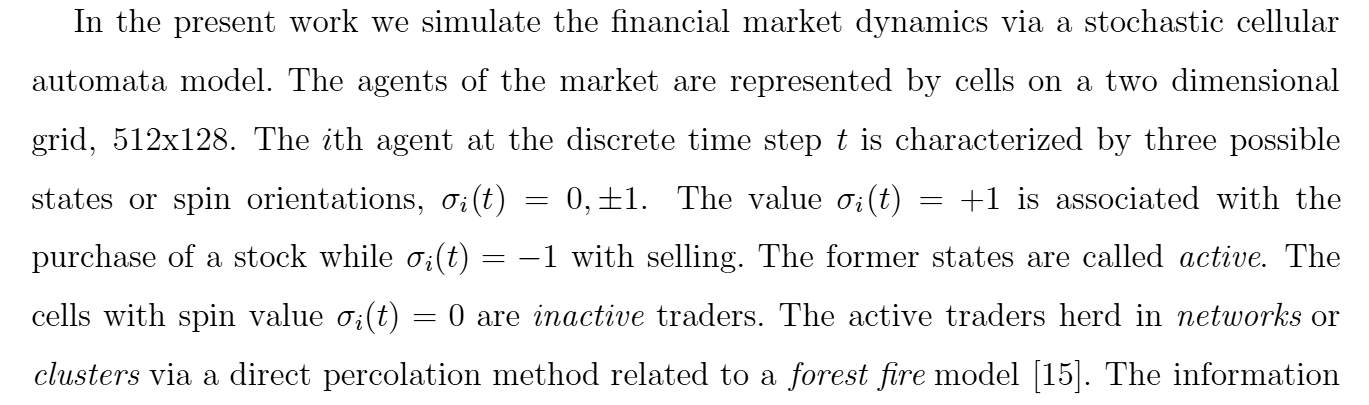

In [4]:
class Trader:
    """Represents a single trader on the grid."""   
    def __init__(self, state=0):
        self.state = state

    def activate(self, new_state: int):
        self.state = new_state
    
    def deactivate(self):
        self.state = 0

class Market:
    """Represents the trading grid."""
    def __init__(self, width: int, height: int):
        """Initialize the grid

        Args:
            width (int): Width of the grid
            height (int): Height of the grid
        """       
        self.width = width
        self.height = height
        self.grid = np.array([[Trader() for _ in range(width)] for _ in range(height)])

    def get_neighbors(self, x: int, y:int):
        """Get the neighbors of a cell at position (x, y) based on Von Neumann neighborhood.

        Args:
            x (int): _description_
            y (int): _description_
        """        
        neumann_directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        return [
            (nx, ny)
            for dx, dy in neumann_directions
            if 0 <= (nx := x + dx) < self.height and 0 <= (ny := y + dy) < self.width
         ]

    def get_clusters(self):

        uf = UnionFind(self.grid)
        
        [
            uf.union(uf._index(x, y), uf._index(nx, ny))
            for x in range(self.height)
            for y in range(self.width)
            if self.grid[x][y].state in [1, -1]  # Active trader
            for nx, ny in self.get_neighbors(x, y)
            if self.grid[nx][ny].state in [1, -1]  # Active neighbor
        ]   

        return uf.get_cluster_configuration()



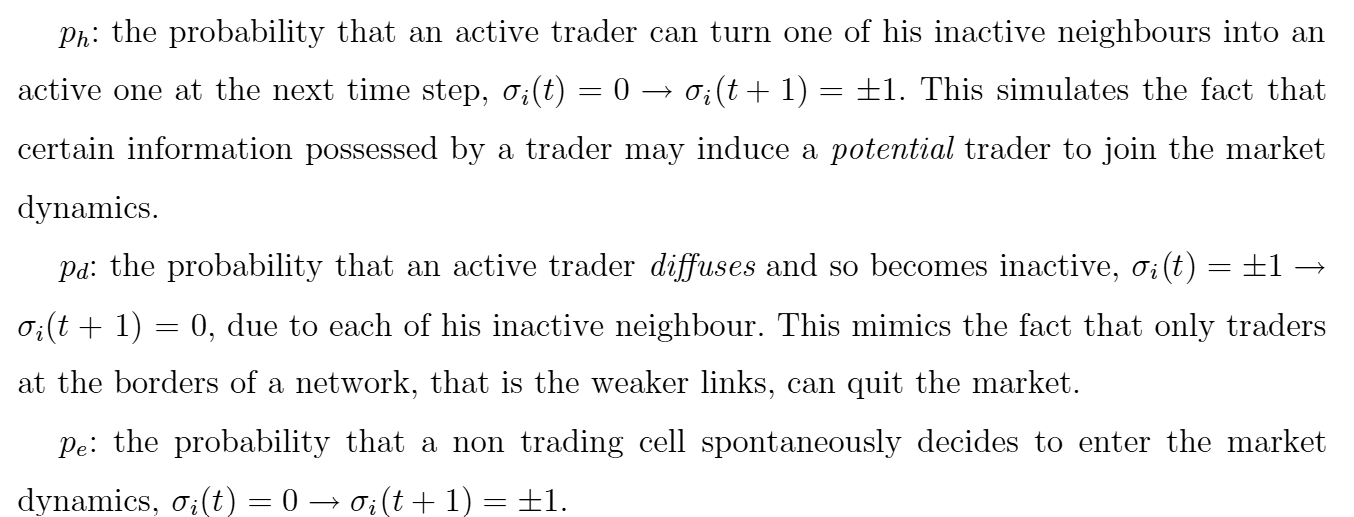

In [5]:
class PercolationDynamics:
    def __init__(self, ph, pd, pe):
        self.pe = pe
        self.ph = ph
        self.pd = pd

    def update_trader(self, grid, x, y):
        BUYER, INACTIVE, SELLER = 1, 0, -1
        trader = grid.grid[x][y]

        if trader.state == INACTIVE:
            if np.random.random() < self.pe:
                trader.activate(random.choice([SELLER, BUYER]))
        else:
            if np.random.random() < self.pd:
                trader.deactivate()
            else:
                for nx, ny in grid.get_neighbors(x, y):
                    neighbor = grid.grid[nx][ny]
                    if neighbor.state == INACTIVE and np.random.random() < self.ph:
                        neighbor.activate(np.random.choice([BUYER, SELLER]))


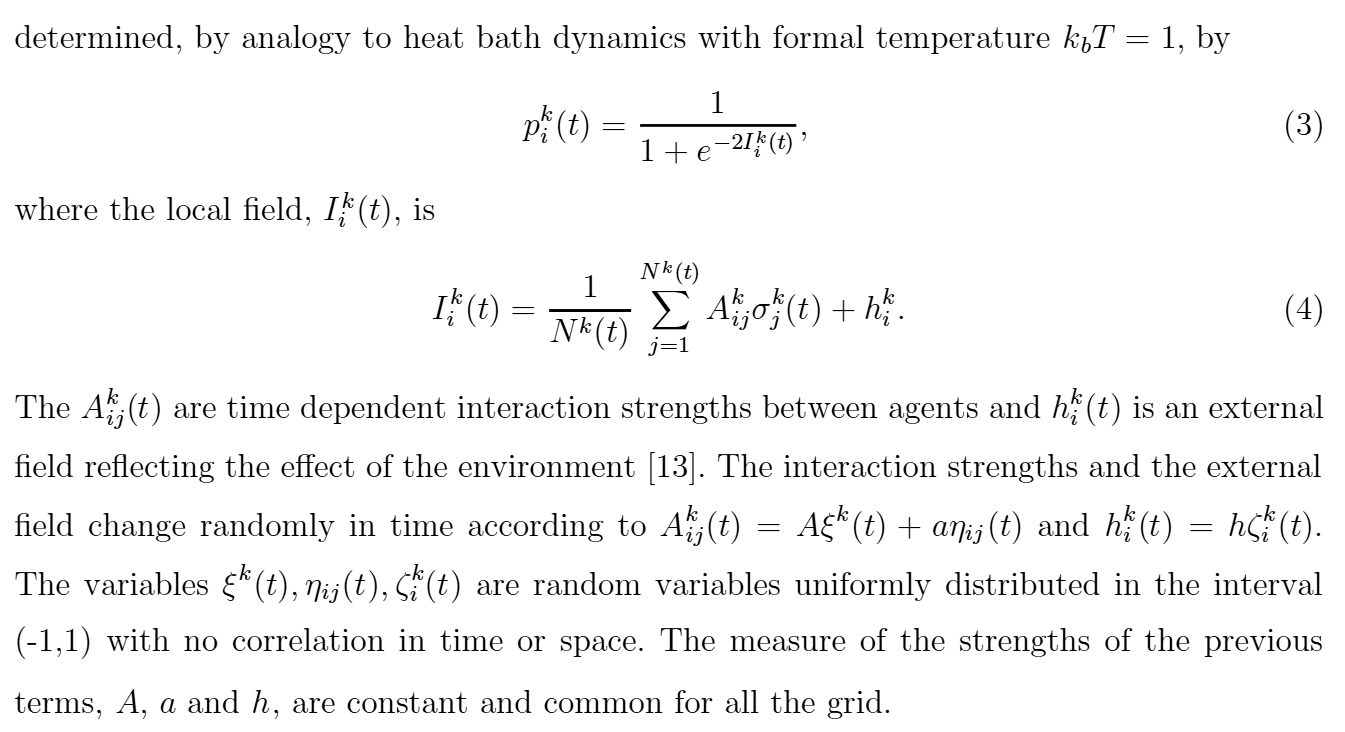

In [7]:
class StochasticTradingDynamics:
    def __init__(self, A, h=0):
        self.A = A
        self.h = h

    def update_traders(self, grid, market):
        BUYER, INACTIVE, SELLER = 1, 0, -1

        # Get cluster configuration
        clusters = market.get_clusters()

        # Temporary list to store updated states
        updated_states = {}

        for cluster in clusters.values():
            cluster_cells = cluster["cells"]  # List of cell coordinates in the cluster
            cluster_size = cluster["size"]

            # Calculate the local field for each trader in the cluster
            for x, y in cluster_cells:
                neighbors = market.get_neighbors(x, y)
                local_field = sum(grid[nx][ny].state for nx, ny in neighbors if grid[nx][ny].state != INACTIVE)
                local_field = (self.A / cluster_size) * local_field + self.h

                # Probability of switching to BUYER or SELLER
                prob_buyer = 1 / (1 + np.exp(-2 * local_field))
                new_state = np.random.choice([BUYER, SELLER], p=[prob_buyer, 1 - prob_buyer])

                # Store new state in temporary dictionary
                updated_states[(x, y)] = new_state

        # Apply updates to the grid after all calculations
        for (x, y), new_state in updated_states.items():
            grid[x][y].state = new_state


{}
{}
{}
{}
{}
{}
{263: {'size': 1, 'cells': [(13, 3)]}}
{263: {'size': 1, 'cells': [(13, 3)]}}
{263: {'size': 3, 'cells': [(13, 3), (13, 4), (14, 4)]}}
{263: {'size': 4, 'cells': [(13, 3), (13, 4), (14, 4), (15, 4)]}}
{263: {'size': 4, 'cells': [(13, 3), (13, 4), (14, 4), (15, 4)]}}
{144: {'size': 1, 'cells': [(7, 4)]}, 243: {'size': 4, 'cells': [(12, 3), (13, 3), (13, 4), (14, 3)]}, 304: {'size': 1, 'cells': [(15, 4)]}}
{89: {'size': 1, 'cells': [(4, 9)]}, 144: {'size': 1, 'cells': [(7, 4)]}, 243: {'size': 8, 'cells': [(12, 3), (13, 3), (13, 4), (14, 3), (14, 4), (15, 4), (16, 4), (17, 4)]}}
{89: {'size': 1, 'cells': [(4, 9)]}, 144: {'size': 1, 'cells': [(7, 4)]}, 192: {'size': 1, 'cells': [(9, 12)]}, 243: {'size': 8, 'cells': [(12, 3), (13, 3), (13, 4), (14, 3), (14, 4), (15, 4), (16, 4), (17, 4)]}}
{18: {'size': 1, 'cells': [(0, 18)]}, 89: {'size': 1, 'cells': [(4, 9)]}, 144: {'size': 1, 'cells': [(7, 4)]}, 191: {'size': 2, 'cells': [(9, 11), (9, 12)]}, 242: {'size': 7, 'cells': [(

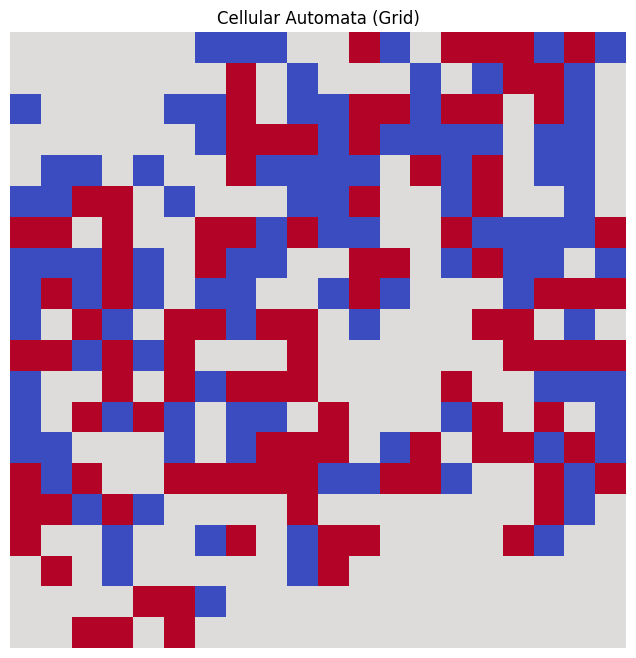

In [8]:
def animate_market(market, dynamics, num_steps=100):
    # Initialize the grid states for animation
    grid_states = []

    fig, ax = plt.subplots(figsize=(8, 8))

    # Initialize grid plot
    grid_plot = ax.imshow(
        np.zeros((market.height, market.width)), cmap="coolwarm", vmin=-1, vmax=1
    )
    ax.set_title("Cellular Automata (Grid)")
    ax.axis("off")

    def update(frame):
        """Update function for each animation frame."""
        # Perform one step of the dynamics
        for x in range(market.height):
            for y in range(market.width):
                dynamics.update_trader(market, x, y)

        # Capture grid state
        grid_state = np.array([[trader.state for trader in row] for row in market.grid])
        grid_states.append(grid_state)

        # Update grid plot
        print(market.get_clusters())
        grid_plot.set_array(grid_states[frame])

        return (grid_plot,)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=num_steps, interval=200, blit=True)

    # Display the animation in the notebook
    return HTML(ani.to_html5_video())


# Example usage
pd = 0.05
pe = 0.001
ph = 0.0485
width, height = 20, 20
market = Market(width, height)
dynamics = PercolationDynamics(ph=ph, pd=pd, pe=pe)

animate_market(market, dynamics, num_steps=100)


In [22]:
class MarketSimulation:
    def __init__(self, width, height, ph, pd, pe, A, h=0, initial_price=100.0):
        self.market = Market(width, height)  # Initialize the grid
        self.percolation = PercolationDynamics(ph, pd, pe)
        self.dynamics = StochasticTradingDynamics(A, h)
        self.price = initial_price
        self.prices = [initial_price]  # Store price evolution
        self.grids = []  # Store grid at each step

    def update_traders(self):
        for x in range(self.market.height):
            for y in range(self.market.width):
                self.percolation.update_trader(self.market, x, y)

        self.dynamics.update_traders(self.market.grid, self.market)

    def compute_price(self):
        clusters = self.market.get_clusters()

        x_t = sum(
            cluster["size"] * sum(self.market.grid[x][y].state for x, y in cluster["cells"]) / cluster["size"]
            for cluster in clusters.values()
        )

        # Normalize price change
        beta = 0.01  # Normalization constant
        self.price *= (1 + beta * x_t)  # Update price proportionally
        self.prices.append(self.price)

    def run_simulation(self, steps):
        for step in range(steps):
            self.update_traders()
            self.compute_price()
            self.grids.append(self.get_grid())  # Store the grid state at each step

    def get_price_series(self):
        return self.prices

    def get_grid(self):
        # Convert grid to numpy array for visualization
        return np.array([[cell.state for cell in row] for row in self.market.grid])



In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_market(simulation, num_steps=100):
    # Run the simulation to precompute the grid states and prices
    simulation.run_simulation(num_steps)  # Precompute the simulation steps

    fig, (ax_grid, ax_price) = plt.subplots(1, 2, figsize=(12, 6))  # Create side-by-side subplots

    # Initialize grid plot
    grid_plot = ax_grid.imshow(
        simulation.grids[0], cmap="coolwarm", vmin=-1, vmax=1
    )
    ax_grid.set_title(f"Step 0")
    ax_grid.axis("off")

    # Initialize price plot (with your specific setup)
    price_line, = ax_price.plot([], [], color='tab:black')
    ax_price.set_title("Price Evolution")
    ax_price.set_xlim(0, num_steps - 1)
    ax_price.set_ylim(min(simulation.prices) * 0.95, max(simulation.prices) * 1.05)
    ax_price.set_xlabel("Step")
    ax_price.set_ylabel("Price")

    def update(frame):
        """Update function for each animation frame."""
        # Update the grid plot with precomputed grid state
        grid_plot.set_array(simulation.grids[frame])
        ax_grid.set_title(f"Step {frame}")
        
        # Update the price plot with all previous price data
        price_line.set_data(range(frame + 1), simulation.prices[:frame + 1])
        ax_price.set_xlim(0, num_steps - 1)  # Keep x-limits fixed
        ax_price.set_ylim(min(simulation.prices) * 0.95, max(simulation.prices) * 1.05)  # Dynamic y-limits
        return grid_plot, price_line

    # Create the animation using precomputed grid states
    ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=200, blit=True)

    # Display the animation in the notebook
    return HTML(ani.to_html5_video())


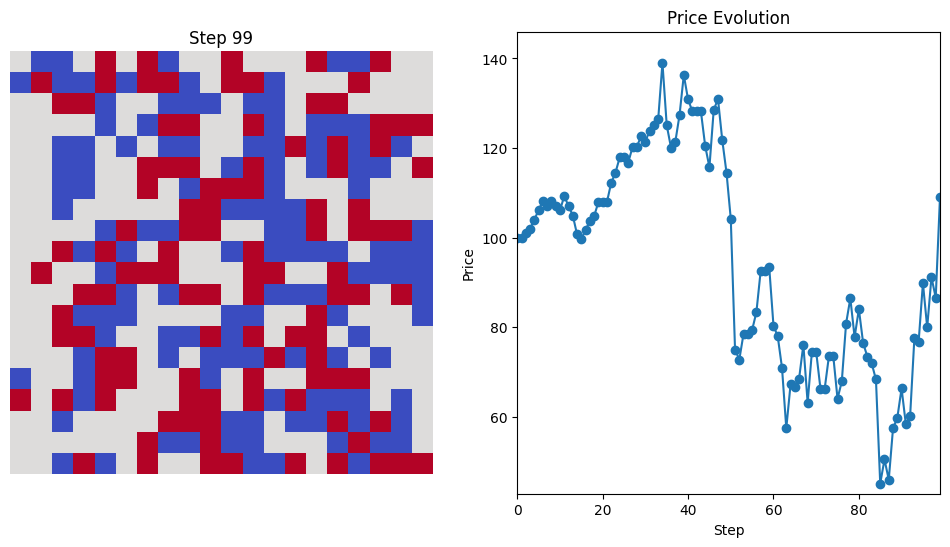

In [28]:
# Run a market simulation
# Initialize simulation parameters
pd = 0.05
pe = 0.001
ph = 0.0485
width, height = 20, 20
A, h = 1.8, 0
steps = 2000

# Run the simulation
simulation = MarketSimulation(width, height, ph, pd, pe, A, h)
animate_market(simulation, 100)